<a href="https://colab.research.google.com/github/nakverma/online-triplet-embedding/blob/master/ImageNet_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from utils import get_dataset, PairGenerator, visualize_deformation, plot_losses
from networks import pairwise_embedding_encoder, pairwise_embedding_network, embedding_encoder
from networks import get_encoding_model, create_autoencoder, resnet_embenc
from losses import contrastive_loss, reconstruction_loss
from training import train_network

from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam
import keras.backend as K
from keras.layers import Input
from keras.models import Model, load_model 
import tensorflow as tf 
from keras.datasets import cifar10


import pandas as pd
import numpy as np 
import cv2
import os 
import itertools
import multiprocessing as mp 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


In [3]:
# !mkdir results
# !mkdir results/exp1

In [4]:
# from run_exp import run as run_DEC
# models, x, y = run_DEC(db='imagenet')
# for model in models:
#     final_DEC_model = model
#     dec_emb = final_DEC_model.extract_features(x)
#     dec_tsne = TSNE()
#     dec_tsne_emb = dec_tsne.fit_transform(dec_emb)
#     print(dec_tsne_emb.shape)
#     plt.figure(figsize=(15, 10))
#     for label in set(y):
#         inds = np.where(y == label)[0]
#         data = dec_tsne_emb[inds]
#         plt.scatter(data[:, 0], data[:, 1], label=label, marker='.', alpha=0.8)
#     plt.legend() 
#     plt.axis('scaled')
#     plt.title("DEC Embedding")
#     plt.show()
#     dec_trainX, dec_testX, dec_trainY, dec_testY = train_test_split(dec_emb, y, stratify=y, shuffle=True)
#     run_knn(dec_trainX, dec_trainY, dec_testX, dec_testY, labels=['0', '1', '2', '3'], experiment_name='dec knn')

In [6]:
####### Helper functions ########

def read_image(args):
    path, color = args 
    if not color:
        return cv2.imread(path, 0)
    else:
        return cv2.imread(path)


def fetch_and_resize(tags, size=(32, 32), hogify=False):
    filepath = 'drive/My Drive/datasets/'
    full_data = []
    full_labels = []
    color = True if len(size) > 2 else False  
    for tag in tags:
        print('processing %s images' % tag)
        dir = filepath + tag
        all_files = [dir + '/' + file_ for file_ in os.listdir(dir)]
        color_args = [color] * len(all_files)
        input_  = list(zip(all_files, color_args))
        print('reading...', end="")
        pool_ = mp.Pool()
        images = pool_.map(read_image, input_)
        data = [cv2.resize(img, (size[0], size[1])) for img in images]
        if hogify:
            data = [hog(dat, feature_vector=True, multichannel=True) for dat in data]
        print('done.')
        labels = [tag] * len(data)
        full_data.extend(data)
        full_labels.extend(labels)
    full_data = np.array(full_data)
    full_labels = np.array(full_labels) 
    return full_data, full_labels


def add_noise(full_data, noise_factor=5):
    new = full_data + noise_factor * np.random.normal(loc=0., scale=1.0, size=full_data.shape)
    new = new.astype(np.uint8)
    return new 


def get_embedding_model(model, input_dim):
    """Retrieves the actual embedding net given a siamese/triplet
    network. 
    
    Args:
        model (TYPE): Description
        input_dim (TYPE): Description
        triplet (bool, optional): Description

    Returns:
        TYPE: Description
    """
    seq = model.get_layer('encoder')
    input_ = Input(input_dim)
    x = seq(input_)
    fin = Model(input_, x)
    return fin

def get_data(img_size=(32, 32, 3)):
    tags = ['dog', 'cat', 'snake', 'lizard']
    data, labels = fetch_and_resize(tags, size=img_size, hogify=True)
    labels = np.array(labels)
    return data, labels

def process_data(data, labels, composite=False, split_size=0.25):
    mammals = ['dog', 'cat', 'bovine', 'deer', 'horses']
    reptile = ['snake', 'lizard']
    Y = labels
    X = data 
    trainX, testX, trainLabels, testLabels = train_test_split(X, Y, test_size=split_size, shuffle=True, stratify=Y)

    # composite labels
    if composite:
        print("using composite labels")
        trainY = np.zeros(trainLabels.shape)
        trainY[np.where(np.isin(trainLabels, mammals))[0]] = 1
        trainY[np.where(np.isin(trainLabels, reptile))[0]] = 0

        testY = np.zeros(len(testLabels))
        testY[np.where(np.isin(testLabels, mammals))[0]] = 1
        testY[np.where(np.isin(testLabels, reptile))[0]] = 0 
    else:
        # individual labels
        print("using individual labels")
        trainY = trainLabels
        testY = testLabels
    
    print('trainX shape: ', trainX.shape)
    print('trainY shape: ', trainY.shape)
    print('testX shape: ', testX.shape)
    print('testY shape:', testY.shape)
    
    return data, labels, trainX, testX, trainY, testY

def load_cifar(inds=[0, 1, 8, 9]):
    (trainX, trainY), (testX, testY) = cifar10.load_data() 

    inds = [0, 1, 8, 9]

    print("using only the following indices in CIFAR: ", str(inds))

    train_inds = np.where(np.isin(trainY, inds))[0]
    test_inds = np.where(np.isin(testY, inds))[0]

    trainX = trainX[train_inds, :]
    trainY = trainY[train_inds]
    testX = testX[test_inds, :]
    testY = testY[test_inds]

    trainX = np.array([hog(dat, multichannel=True, feature_vector=True) for dat in trainX])
    testX = np.array([hog(dat, multichannel=True, feature_vector=True) for dat in testX])

    return np.concatenate([trainX, testX]), np.concatenate([trainY, testY]).flatten() 

def load_data(dataset_name):
    if dataset_name == 'imagenet':
        return get_data()
    elif dataset_name == 'cifar10':
        return load_cifar()

def get_data(img_size=(32, 32, 3)):
    tags = ['dog', 'cat', 'snake', 'lizard']
    data, labels = fetch_and_resize(tags, size=img_size, hogify=True)
    labels = np.array(labels)
    return data, labels

def process_data(data, labels, composite=False, split_size=0.25):
    mammals = ['dog', 'cat', 'bovine', 'deer', 'horses']
    reptile = ['snake', 'lizard']
    Y = labels
    X = data 
    trainX, testX, trainLabels, testLabels = train_test_split(X, Y, test_size=split_size, shuffle=True, stratify=Y)

    # composite labels
    if composite:
        print("using composite labels")
        trainY = np.zeros(trainLabels.shape)
        trainY[np.where(np.isin(trainLabels, mammals))[0]] = 1
        trainY[np.where(np.isin(trainLabels, reptile))[0]] = 0

        testY = np.zeros(len(testLabels))
        testY[np.where(np.isin(testLabels, mammals))[0]] = 1
        testY[np.where(np.isin(testLabels, reptile))[0]] = 0 
    else:
        # individual labels
        print("using individual labels")
        trainY = trainLabels
        testY = testLabels
    
    print('trainX shape: ', trainX.shape)
    print('trainY shape: ', trainY.shape)
    print('testX shape: ', testX.shape)
    print('testY shape:', testY.shape)
    
    return data, labels, trainX, testX, trainY, testY

def load_cifar(inds=[0, 1, 8, 9]):
    (trainX, trainY), (testX, testY) = cifar10.load_data() 

    inds = [0, 1, 8, 9]

    print("using only the following indices in CIFAR: ", str(inds))

    train_inds = np.where(np.isin(trainY, inds))[0]
    test_inds = np.where(np.isin(testY, inds))[0]

    trainX = trainX[train_inds, :]
    trainY = trainY[train_inds]
    testX = testX[test_inds, :]
    testY = testY[test_inds]

    trainX = np.array([hog(dat, multichannel=True, feature_vector=True) for dat in trainX])
    testX = np.array([hog(dat, multichannel=True, feature_vector=True) for dat in testX])

    return np.concatenate([trainX, testX]), np.concatenate([trainY, testY]).flatten() 

def load_data(dataset_name):
    if dataset_name == 'imagenet':
        return get_data()
    elif dataset_name == 'cifar10':
        return load_cifar()


In [ ]:
# if len(img_size) > 2:
#     X = data 
# else:
#     X = data.reshape(-1, np.product(img_size))
# X = noisy_data 
# X = data.reshape(-1, np.product(data.shape[1:]))
# trainX, testX, rawtrain_X, rawtestX, trainLabels, testLabels = train_test_split(X, data, Y, test_size=0.25, shuffle=True, stratify=Y)

# raw_hogs = np.array([hog(dat) for dat in rawtrain_X])
# noisy_hogs = np.array([hog(dat) for dat in trainX])
# noisy_hogs.shape

# figuring out working hyperparams for the autoencoder section.
# autoenc_input_dim = (1, raw_hogs.shape[-1])
# latent_dim = 2
# autoencoder = create_autoencoder(autoenc_input_dim, latent_dim, layers=[324], 
#                                  f='relu', 
#                                  bottleneck_activation='sigmoid',
#                                  reconstruction_activation='linear',
#                                  tied=True, compile_=True)
# autoencoder.get_layer('encoder').summary()
# autoencoder.get_layer('decoder').summary()

# epochs = 100

# history = autoencoder.fit(noisy_hogs.reshape(-1, 1, noisy_hogs.shape[-1]), 
#                           raw_hogs.reshape(-1, 1, raw_hogs.shape[-1]), 
#                           epochs=epochs, verbose=0, validation_split=0.2)

# # checking if tied weights are in fact tied. 
# encoder = autoencoder.get_layer('encoder')
# decoder = autoencoder.get_layer('decoder')

# print(encoder.layers[-1].kernel)
# print(decoder.layers[1].kernel)


# plt.plot(range(epochs), history.history['val_loss'])
# plt.show()

# checking the output from the autoencoder.
# # plt.imshow(testX[0].reshape(img_size))
# plt.imshow(testX[0])
# plt.show()
# predicted = autoencoder.predict(testX.reshape(-1, 1, testX.shape[-1]))
# # predicted = predicted.reshape(-1, np.product(img_size)
# predicted = predicted.reshape(-1, predicted.shape[-1])
# plt.imshow(predicted[0])
# plt.show()

# # visualize the latent dim. 
# def vis(predicted, Y):
#     from matplotlib.pyplot import cm
#     colors = iter(cm.rainbow(np.linspace(0, 1, len(set(Y)))))
#     plt.figure(figsize=(15, 10))
#     for cl in set(Y):
#         c = next(colors)
#         inds = np.where(Y == cl)[0]
#         cl_data = predicted[inds, :]
#         plt.scatter(cl_data[:, 0], cl_data[:, 1], alpha=0.6, marker='.', label=cl, color=c)
#     plt.legend()
#     plt.title("latent dim visualization")
#     plt.show()

# predicted = encoder.predict(noisy_hogs.reshape(-1, 1, noisy_hogs.shape[-1]))
# predicted = predicted.reshape(-1, predicted.shape[-1])
# vis(predicted, trainY) 

In [8]:
def run_knn(trainX, trainY, testX, testY, labels=['dog', 'cat', 'snake', 'lizard'], experiment_name=""):
    print("========= KNN Results: %s ==========" % experiment_name)
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn.fit(trainX, trainY)   
    train_pred = knn.predict(trainX)
    test_pred = knn.predict(testX)
    print("Training Accuracy: ", knn.score(trainX, trainY))
    print("Training Confusion Matrix: \n ", confusion_matrix(trainY, train_pred, labels=labels))
    print("Test Accuracy: ", knn.score(testX, testY))
    print("Test Confusion Matrix: \n ", confusion_matrix(testY, test_pred, labels=labels))
    print('====================================================')

In [15]:
def training_loop(input_):

    # get the inputs 
    mu, output_dim, perplexity, X, Y = input_[0], input_[1], input_[2], input_[3], input_[4]
    
    # fetch the data.
    X, Y, trainX, testX, trainY, testY = process_data(X, Y, composite=False, split_size=0.25)

    # run KNN on initial input space and visualize with t-SNE
    run_knn(trainX, trainY, testX, testY, experiment_name="Initial HOG Space", labels=list(set(Y)))
    initial_tsne = TSNE() 
    HOG_transformed = initial_tsne.fit_transform(X)
    plt.figure(figsize=(15, 10))
    for lab in set(Y):
        inds = np.where(Y == lab)[0]
        dat = HOG_transformed[inds, :]
        plt.scatter(dat[:, 0], dat[:, 1], label=lab, alpha=0.8, marker='.')
    plt.title("t-SNE of HOG Space")
    plt.legend() 
    plt.axis('scaled')
    plt.show()
        
    ## define training params. 
    margin = 5
    p_norm = 2 
    batch_size = 128

    ## specify model parameters and losses. 
    model_type = 'embenc'
    optimizer = Adam(learning_rate=0.001)
    activation = 'relu'
    num_neurons = 500
    input_dim = (1, trainX.shape[-1])
    latent_dim = trainX.shape[-1]
    loss1 = lambda y_true, y_pred: contrastive_loss(y_true, y_pred, margin=margin, norm=p_norm)
    loss2 = lambda y_true, y_pred: reconstruction_loss(y_true, y_pred)
    losses = {'reconstruction': loss2,
              'embedding': loss1}
    epochs = 5
    max_iters = 1500

    print("max iters: ", max_iters)
    ## create generator
    datagen = PairGenerator(trainX, trainY)

    ## create the model. 
    if model_type == 'embenc':
        # model = resnet_embenc(img_size, output_dim, activation, optimizer, losses, mu=1,
        #                       autoencoding_layers=[750, 500, 250],
        #                       embedding_layers=[500, 500, 2000, 10],
        #                       prior_trainable=True,
        #                       drop_pooling=False)
        print("mu: ", mu)
        print("output_dim: ", output_dim)
        print("perplexity: ", perplexity)
        print("X.shape: ", X.shape)
        print("Y.shape: ", Y.shape)

        model = embedding_encoder(input_dim, 
                                  output_dim, 
                                  losses, 
                                  optimizer,
                                  layers=[500, 500, 2000, 10],
                                  encoder_activation=activation,
                                  decoder_activation='relu',
                                  mu=mu,
                                  regularizer='l1',
                                  dropout_val=0.2,
                                  tied=True)

        # model2 = pairwise_embedding_encoder(input_dim, 
        #                                    output_dim=output_dim, 
        #                                    num_neurons=num_neurons,
        #                                    losses=losses, optimizer=optimizer, f=activation,
        #                                    mu=mu, 
        #                                    embedding_layers=[500, 500, 2000, 10],
        #                                    autoencoding_layers=[10],
        #                                    latent_dim=2000,
        #                                    decoding_layers=[500, 500], 
        #                                    dropout_val=0.4,
        #                                    autoencoder_dropout=0.4,
        #                                    autoencoder_regularizer='l1',
        #                                    embedding_regularizer='l1')

    elif model_type == 'siamese':
        model = pairwise_embedding_network(input_dim, output_dim, num_neurons, loss1, optimizer, f=activation)


    ## train network 
    model, loss_vals = train_network(model, datagen, batch_size, max_iters, type_=model_type)

    ## get the embedding model. 
    embedding_model = get_embedding_model(model, input_dim=(1, trainX.shape[-1]))
    # embedding_model.get_layer('embeddingnet').summary()

    # visualize the embeddings. 
    embedding_name = 'mu=' + str(mu) + ', latent=' + str(output_dim)

    return visualize_embedding(embedding_model, trainX, testX, trainY, testY, plot_train=True, 
                               plot_test=True, perplexity=perplexity, name_=embedding_name, labels=list(set(Y)), mu=mu)
    
    # return visualize_embedding(embedding_model, X, X, Y, Y, mu=mu, plot_train=True, plot_test=False, 
    #                            perplexity=perplexity, name_=embedding_name, labels=list(set(Y)))

# ## visualize model topology. 
# p1 = plot_model(model, 'full_model.png', expand_nested=True, show_shapes=True)
# p2 = plot_model(model.get_layer('encodingnet'), 'encodingnet.png', expand_nested=True, show_shapes=True)
# p3 = plot_model(model.get_layer('embeddingnet'), 'embeddingnet.png', expand_nested=True, show_shapes=True)

In [16]:
 def visualize_embedding(embedding_model, trainX, testX, 
                        trainLabels, testLabels, 
                        plot_train=True, plot_test=True, mu=None,
                        composite_tsne=True,
                        **kwargs):

    # get the embedding by passing datasets through the embedding network.     
    train_embedding = embedding_model.predict(trainX.reshape(-1, 1, trainX.shape[-1]))
    test_embedding = embedding_model.predict(testX.reshape(-1, 1, testX.shape[-1]))

    # reshape from 3 dims down to 2 dim array. 
    train_embedding = train_embedding.reshape(-1, train_embedding.shape[-1])
    test_embedding = test_embedding.reshape(-1, test_embedding.shape[-1])

    # print details
    print("train embedding dims: ", train_embedding.shape)
    print("test embedding dims: ", test_embedding.shape)

    # save the CSV files.
    train_name = kwargs['name_'] + '_training'
    test_name = kwargs['name_'] + '_test'

    train = np.hstack([train_embedding, trainLabels.reshape(-1, 1)])
    test = np.hstack([test_embedding, testLabels.reshape(-1, 1)])

    pd.DataFrame(train).to_csv(train_name + '.csv')
    pd.DataFrame(test).to_csv(test_name + '.csv')

    # KNN on the embedding to assess quality. 
    run_knn(train_embedding, trainLabels, test_embedding, testLabels, experiment_name="latent dimension embedding", labels=kwargs['labels'])

    # case: embedding dimension is 2, no need for t-sne. 
    if train_embedding.shape[-1] == 2:
        colors = iter(cm.rainbow(np.linspace(0, 1, len(set(testLabels)))))
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111)
        for label in set(trainLabels):
            c = next(colors)
            train_inds = np.where(trainLabels == label)[0]
            test_inds = np.where(testLabels == label)[0]

            train_emb = train_embedding[train_inds, :]
            test_emb = test_embedding[test_inds, :]
            
            if plot_train:
                ax.scatter(train_emb[:, 0], train_emb[:, 1], alpha=0.5, color=c, marker='.', label=label)
            if plot_test:
                ax.scatter(test_emb[:, 0], test_emb[:, 1], alpha=0.8, color=c, label=label, marker='o')
            
        # min_tick = min(ax.get_xticks().min(), ax.get_yticks().min())
        # max_tick = max(ax.get_xticks().max(), ax.get_yticks().max())
        # ax.set_xticks(np.linspace(min_tick, max_tick, 10))
        # ax.set_yticks(np.linspace(min_tick, max_tick, 10))
        
        plt.title("Embedding - train and test")
        plt.legend() 
        plt.grid()
        plt.show()
    
        return train_embedding, test_embedding

    # embedding dimension > 2, tsne down to 2 dims. 
    else:
        # fit tsne. 
        print("output dims = %s > 2, fitting and plotting t-SNE visualization..." % train_embedding.shape[-1], end="")

        if composite_tsne:
            trainX = np.vstack([train_embedding, test_embedding])
            trainY = np.vstack([trainLabels.reshape(-1, 1), testLabels.reshape(-1, 1)])
            plot_test = False

        # get colormap as iterable
        colors = iter(cm.rainbow(np.linspace(0, 1, len(set(testLabels)))))

        plt.figure(figsize=(15,15))
        if 'perplexity' in kwargs:
            perp = kwargs['perplexity']
        else:
            perp = 30

        # compute the t-SNE embeddings. 
        if plot_train:
            tsne = TSNE(n_components=2, perplexity=perp, n_iter=2500)
            train_latent_dim = tsne.fit_transform(train_embedding)
            print(train_latent_dim.shape)
            print(trainLabels.shape)
            train_tsne = np.hstack([train_latent_dim, trainLabels.reshape(-1, 1)])
            pd.DataFrame(train_tsne).to_csv(train_name + '_tsne.csv')
        
        if plot_test:
            tsne = TSNE(n_components=2, perplexity=perp, n_iter=2500)
            test_latent_dim = tsne.fit_transform(test_embedding)
            test_tsne = np.hstack([test_latent_dim, testLabels.reshape(-1, 1)])
            pd.DataFrame(test_tsne).to_csv(test_name + '_tsne.csv')

        for lab in set(trainLabels):
            c = next(colors)
            if plot_train:
                # plot for each class. 
                inds = np.where(trainLabels == lab)[0]
                lab_train_latent = train_latent_dim[inds, :]
                marker = '.' if 'train_marker' not in kwargs else kwargs['train_marker']
                plt.scatter(lab_train_latent[:, 0], lab_train_latent[:, 1], label=lab, marker=marker, color=c, alpha=0.6)

            if plot_test:
                inds = np.where(testLabels == lab)[0]
                lab_test_latent = test_latent_dim[inds, :]
                marker = 'v' if 'test_marker' not in kwargs else kwargs['test_marker']
                plt.scatter(lab_test_latent[:, 0], lab_test_latent[:, 1], label=lab, marker=marker, color=c, alpha=0.6)

        print("done.")
        plt.legend()
        plt.axis('scaled')

        if plot_train and not plot_test:
            title = "training set"
        if plot_test and not plot_train:
            title = "test set"
        if plot_train and plot_test:
            title = "training & test set"
        plt.title("latent dim = %s - %s. mu = %s, perplexity = %s " % (train_embedding.shape[-1], title, mu, perp))
        plt.show()

        return embedding_model 
        

In [17]:
# load data. 
dataset_name = 'cifar10'
X, Y = load_data(dataset_name)
if dataset_name == 'cifar10':
    _, X, _, Y = train_test_split(X, Y, stratify=Y, shuffle=True, test_size=0.1)
print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

using only the following indices in CIFAR:  [0, 1, 8, 9]
X.shape:  (2400, 324)
Y.shape:  (2400,)


In [18]:
mu_vals = [0, 0.25, 0.5, 0.75, 1]
perp_vals = [30]
output_dim = [100]
Xs = [X]
Ys = [Y]

In [19]:
inputs = list(itertools.product(mu_vals, output_dim, perp_vals, Xs, Ys))

using individual labels
trainX shape:  (1800, 324)
trainY shape:  (1800,)
testX shape:  (600, 324)
testY shape: (600,)
========= KNN Results: Initial HOG Space ==========
Training Accuracy:  0.77
Training Confusion Matrix: 
  [[318  33  29  70]
 [ 17 382  24  27]
 [ 17  44 350  39]
 [ 33  52  29 336]]
Test Accuracy:  0.6783333333333333
Test Confusion Matrix: 
  [[ 95  19   9  27]
 [  9 113  19   9]
 [  4  19 113  14]
 [ 30  22  12  86]]


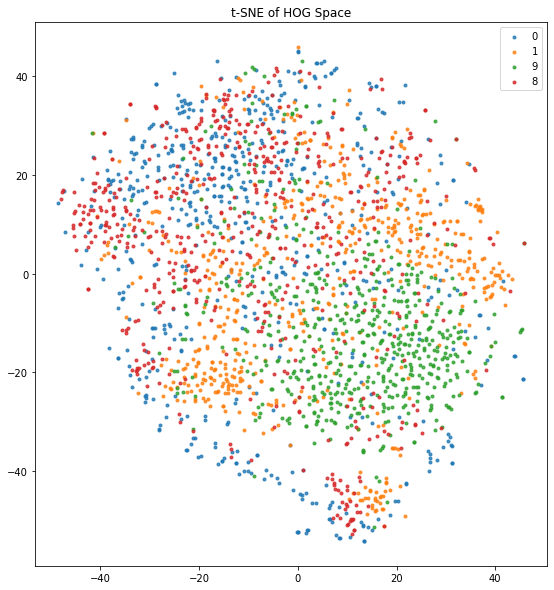

max iters:  1500
mu:  0
output_dim:  100
perplexity:  30
X.shape:  (2400, 324)
Y.shape:  (2400,)
['dense_8', 'batch_normalization_16', 'dropout_16', 'dense_9', 'batch_normalization_17', 'dropout_17', 'dense_10', 'batch_normalization_18', 'dropout_18', 'dense_11', 'batch_normalization_19', 'dropout_19', 'encoded_inputs']
iteration 100. (contrastive loss, reconstruction loss): (11.486698150634766, 58.9532585144043)
iteration 200. (contrastive loss, reconstruction loss): (9.688382148742676, 12.333975791931152)
iteration 300. (contrastive loss, reconstruction loss): (6.6622490882873535, 3.7779927253723145)
iteration 400. (contrastive loss, reconstruction loss): (4.820271015167236, 2.9988114833831787)
iteration 500. (contrastive loss, reconstruction loss): (3.865312337875366, 2.9529519081115723)
iteration 600. (contrastive loss, reconstruction loss): (3.37031626701355, 2.7213399410247803)
iteration 700. (contrastive loss, reconstruction loss): (3.242002010345459, 2.6260759830474854)
iterati

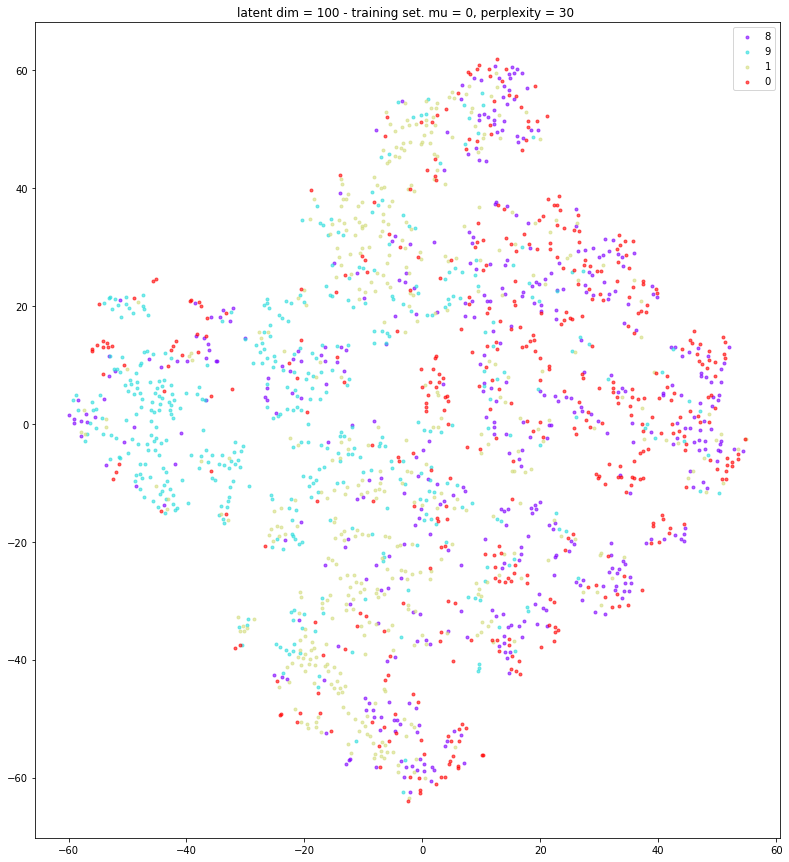

using individual labels
trainX shape:  (1800, 324)
trainY shape:  (1800,)
testX shape:  (600, 324)
testY shape: (600,)
========= KNN Results: Initial HOG Space ==========
Training Accuracy:  0.7966666666666666
Training Confusion Matrix: 
  [[337  28  31  54]
 [ 14 383  29  24]
 [ 17  24 377  32]
 [ 36  43  34 337]]
Test Accuracy:  0.665
Test Confusion Matrix: 
  [[ 88  11  10  41]
 [  6 113  18  13]
 [  5  23 106  16]
 [ 16  23  19  92]]


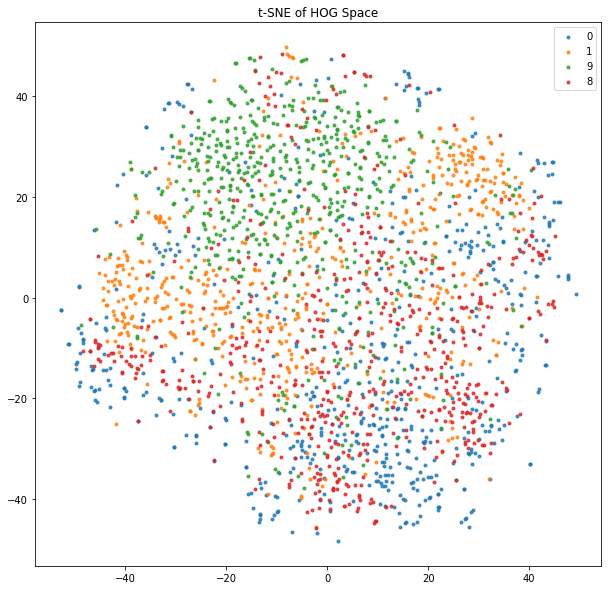

max iters:  1500
mu:  0.25
output_dim:  100
perplexity:  30
X.shape:  (2400, 324)
Y.shape:  (2400,)
['dense_12', 'batch_normalization_24', 'dropout_24', 'dense_13', 'batch_normalization_25', 'dropout_25', 'dense_14', 'batch_normalization_26', 'dropout_26', 'dense_15', 'batch_normalization_27', 'dropout_27', 'encoded_inputs']
iteration 100. (contrastive loss, reconstruction loss): (5.631668567657471, 54.77037048339844)
iteration 200. (contrastive loss, reconstruction loss): (3.5384254455566406, 9.646902084350586)
iteration 300. (contrastive loss, reconstruction loss): (3.3005452156066895, 3.5262811183929443)
iteration 400. (contrastive loss, reconstruction loss): (3.2088849544525146, 3.0926449298858643)
iteration 500. (contrastive loss, reconstruction loss): (3.1854801177978516, 2.7560698986053467)
iteration 600. (contrastive loss, reconstruction loss): (3.1533865928649902, 2.683565378189087)
iteration 700. (contrastive loss, reconstruction loss): (3.0535624027252197, 2.680624485015869)

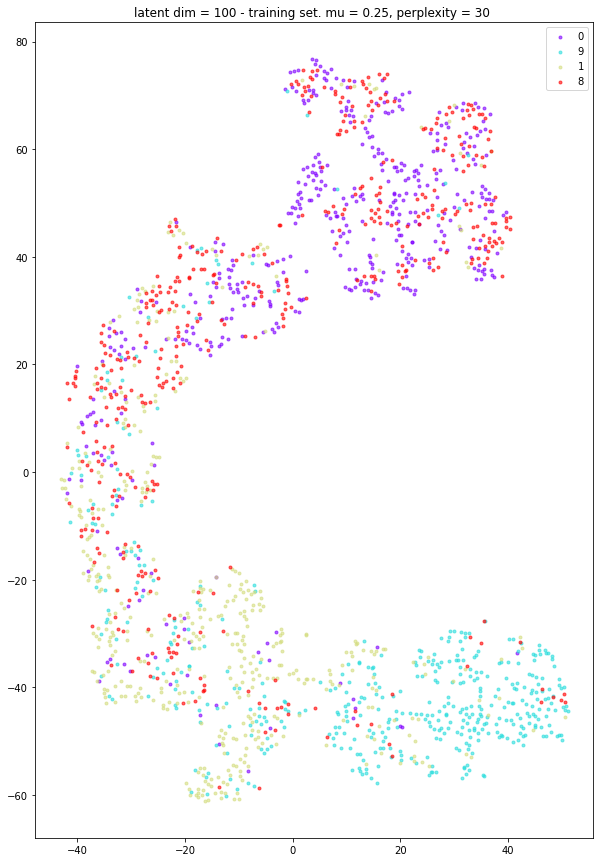

using individual labels
trainX shape:  (1800, 324)
trainY shape:  (1800,)
testX shape:  (600, 324)
testY shape: (600,)
========= KNN Results: Initial HOG Space ==========
Training Accuracy:  0.7883333333333333
Training Confusion Matrix: 
  [[327  40  23  60]
 [ 18 384  33  15]
 [ 13  36 369  32]
 [ 36  41  34 339]]
Test Accuracy:  0.62
Test Confusion Matrix: 
  [[ 82  20  14  34]
 [  8 110  18  14]
 [  3  34  92  21]
 [ 17  32  13  88]]


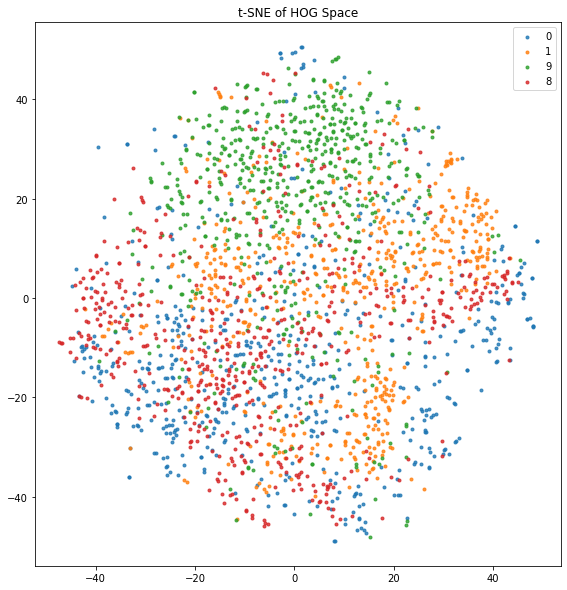

max iters:  1500
mu:  0.5
output_dim:  100
perplexity:  30
X.shape:  (2400, 324)
Y.shape:  (2400,)
['dense_16', 'batch_normalization_32', 'dropout_32', 'dense_17', 'batch_normalization_33', 'dropout_33', 'dense_18', 'batch_normalization_34', 'dropout_34', 'dense_19', 'batch_normalization_35', 'dropout_35', 'encoded_inputs']
iteration 100. (contrastive loss, reconstruction loss): (4.420373916625977, 52.351009368896484)
iteration 200. (contrastive loss, reconstruction loss): (3.1469357013702393, 8.23814868927002)
iteration 300. (contrastive loss, reconstruction loss): (2.9652836322784424, 3.575413942337036)
iteration 400. (contrastive loss, reconstruction loss): (3.026634931564331, 3.1514346599578857)
iteration 500. (contrastive loss, reconstruction loss): (2.8797430992126465, 2.95159912109375)
iteration 600. (contrastive loss, reconstruction loss): (2.616060733795166, 2.9953722953796387)
iteration 700. (contrastive loss, reconstruction loss): (2.7929861545562744, 2.9169921875)
iteration

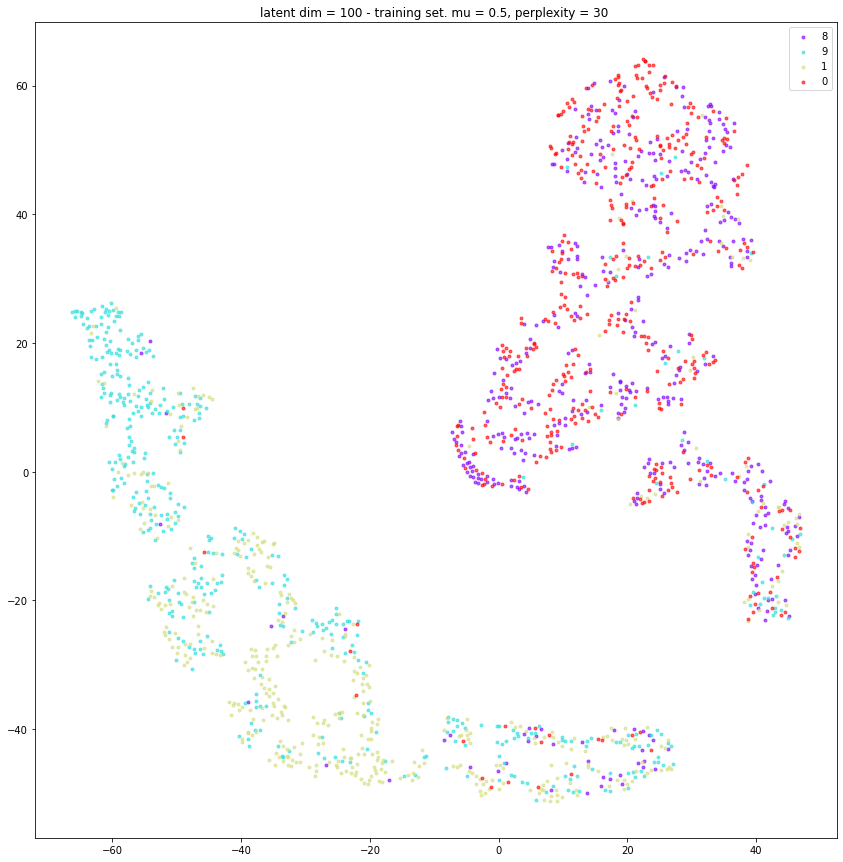

using individual labels
trainX shape:  (1800, 324)
trainY shape:  (1800,)
testX shape:  (600, 324)
testY shape: (600,)
========= KNN Results: Initial HOG Space ==========
Training Accuracy:  0.7838888888888889
Training Confusion Matrix: 
  [[328  39  29  54]
 [ 14 373  31  32]
 [ 15  36 373  26]
 [ 26  48  39 337]]
Test Accuracy:  0.6783333333333333
Test Confusion Matrix: 
  [[ 84  20  12  34]
 [  5 117  20   8]
 [  6  14 110  20]
 [ 22  25   7  96]]


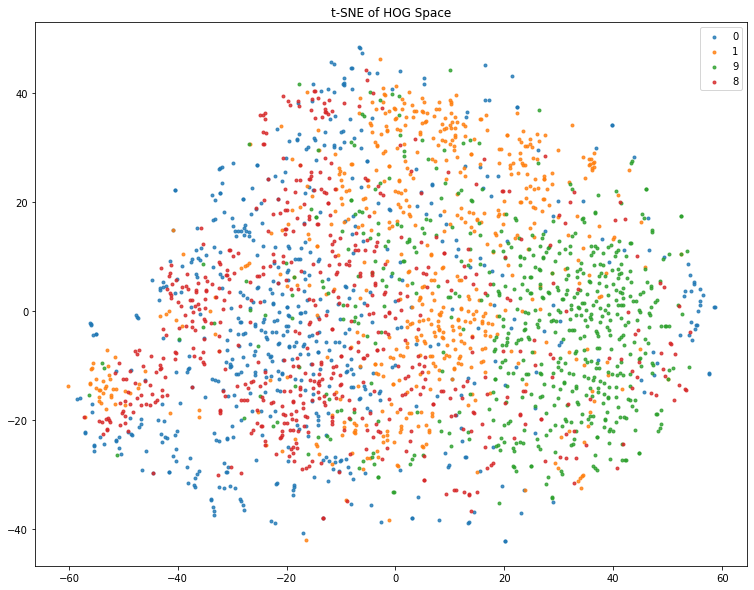

max iters:  1500
mu:  0.75
output_dim:  100
perplexity:  30
X.shape:  (2400, 324)
Y.shape:  (2400,)
['dense_20', 'batch_normalization_40', 'dropout_40', 'dense_21', 'batch_normalization_41', 'dropout_41', 'dense_22', 'batch_normalization_42', 'dropout_42', 'dense_23', 'batch_normalization_43', 'dropout_43', 'encoded_inputs']
iteration 100. (contrastive loss, reconstruction loss): (3.545931100845337, 35.77018356323242)
iteration 200. (contrastive loss, reconstruction loss): (3.072568416595459, 5.717321872711182)
iteration 300. (contrastive loss, reconstruction loss): (2.9110143184661865, 3.7507033348083496)
iteration 400. (contrastive loss, reconstruction loss): (2.920900821685791, 3.253239393234253)
iteration 500. (contrastive loss, reconstruction loss): (2.8936731815338135, 3.1934635639190674)
iteration 600. (contrastive loss, reconstruction loss): (2.7057390213012695, 3.172598361968994)
iteration 700. (contrastive loss, reconstruction loss): (2.6659209728240967, 3.159327268600464)
it

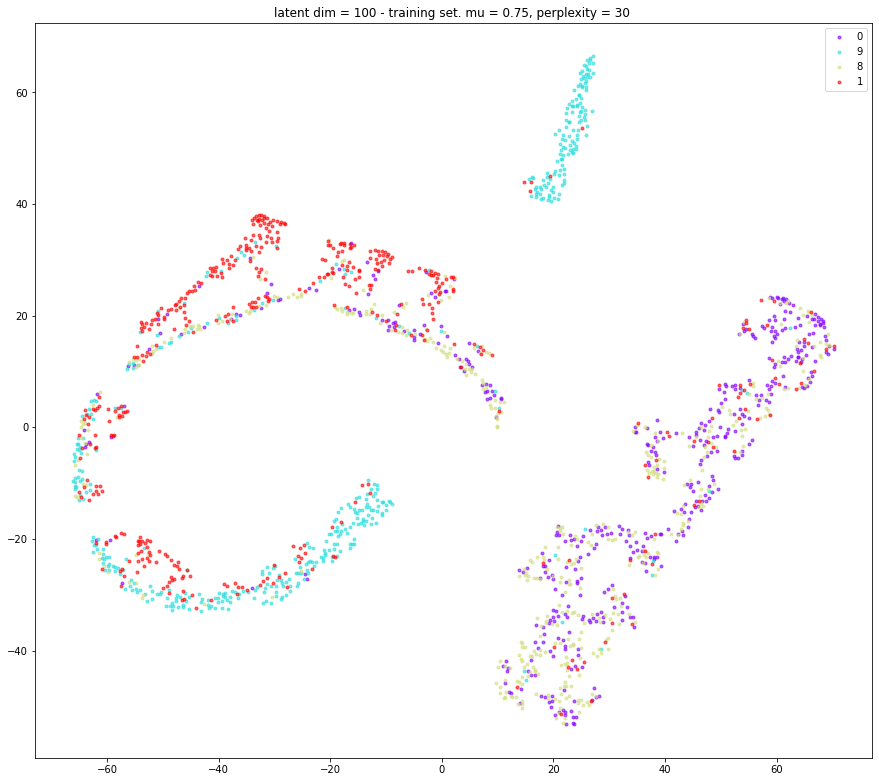

using individual labels
trainX shape:  (1800, 324)
trainY shape:  (1800,)
testX shape:  (600, 324)
testY shape: (600,)
========= KNN Results: Initial HOG Space ==========
Training Accuracy:  0.7866666666666666
Training Confusion Matrix: 
  [[330  34  27  59]
 [ 16 384  25  25]
 [ 13  42 362  33]
 [ 34  43  33 340]]
Test Accuracy:  0.6666666666666666
Test Confusion Matrix: 
  [[ 85  20  14  31]
 [  3 114  17  16]
 [  5  19 107  19]
 [ 25  22   9  94]]


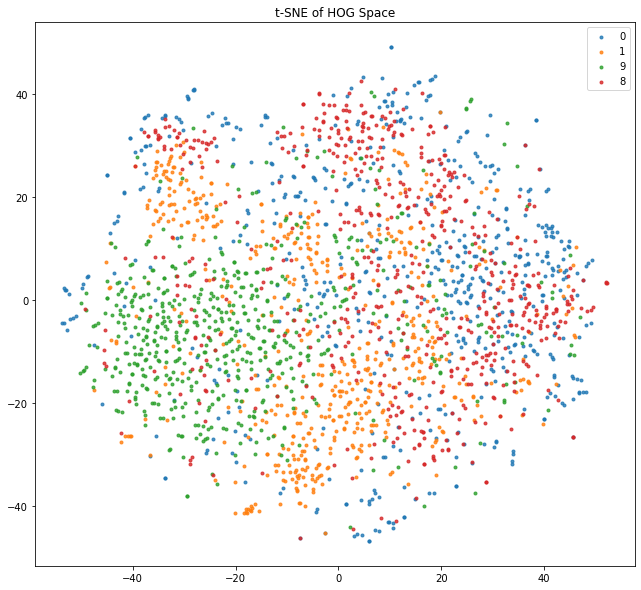

max iters:  1500
mu:  1
output_dim:  100
perplexity:  30
X.shape:  (2400, 324)
Y.shape:  (2400,)
['dense_24', 'batch_normalization_48', 'dropout_48', 'dense_25', 'batch_normalization_49', 'dropout_49', 'dense_26', 'batch_normalization_50', 'dropout_50', 'dense_27', 'batch_normalization_51', 'dropout_51', 'encoded_inputs']
iteration 100. (contrastive loss, reconstruction loss): (3.0251810550689697, 30.54834747314453)
iteration 200. (contrastive loss, reconstruction loss): (2.8613979816436768, 10.448613166809082)
iteration 300. (contrastive loss, reconstruction loss): (2.912057876586914, 10.25839900970459)
iteration 400. (contrastive loss, reconstruction loss): (2.739638090133667, 10.298117637634277)
iteration 500. (contrastive loss, reconstruction loss): (2.6039249897003174, 10.582742691040039)
iteration 600. (contrastive loss, reconstruction loss): (2.747037649154663, 11.02052116394043)
iteration 700. (contrastive loss, reconstruction loss): (2.124013662338257, 11.209932327270508)
iter

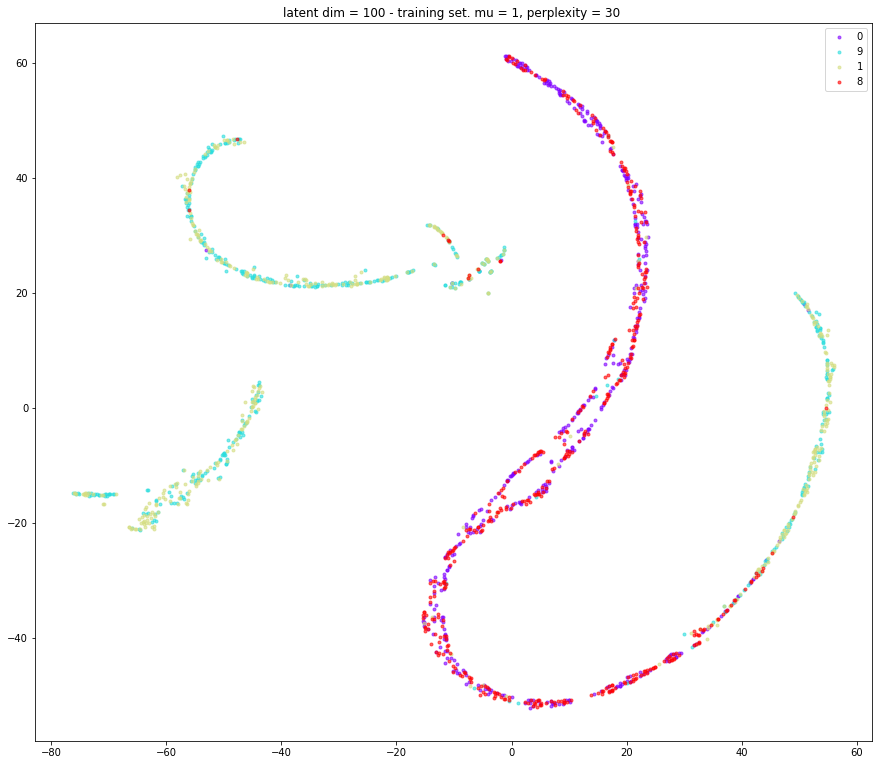

In [20]:
for input in inputs:
    model = training_loop(input)

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd 
img_w, img_h = 32,32
zoom = 0.5

# subsample a section of both dataframes in a stratified fashion. 
inds = [] 
for cl in set(labels):
    cl_inds = np.random.choice(np.where(labels == cl)[0],
                               100,
                               replace=False)
    inds.extend(cl_inds)

plt_trainX = pd.DataFrame(trainX[inds, :]).reset_index(drop=True)
plt_embedding = embedding[inds, :]
print(plt_embedding.shape)

fig, ax = plt.subplots(figsize=(24,16))

for i, row in plt_trainX.iterrows():
    image = row.values.reshape((img_w, img_h))
    im = OffsetImage(image, zoom=0.3)
    ab = AnnotationBbox(im, (plt_embedding[i, 0], plt_embedding[i, 1]), xycoords='data', frameon=False)
    ax.add_artist(ab)
    ax.update_datalim([(embedding[i, 0], embedding[i, 1])])
    ax.autoscale()